In [23]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

In [24]:
# Initialization of weights and bias with a normal distribution
def initialization(input_size_, hidden_size_, Mu_, STD_, nl):
    bname = 'b{}'.format(nl)
    Wname = 'W{}'.format(nl)
    WR = tf.Variable(tf.random.normal([input_size_, hidden_size_], mean=Mu_, stddev=STD_), name=Wname)
    BR = tf.Variable(tf.random.normal([hidden_size_], mean=Mu_, stddev=STD_), name=bname)
    return WR,BR

# Define the forward function to compute the output of the neural network
def forward(X, i, activation, depth_):
    with tf.GradientTape() as tape:
        tape.watch([param for param in [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)]])
        
        A = X
        for j in range(depth_):
            Z = tf.add(tf.matmul(A, sigma_w/lsizes[j]**0.5*Ws[i, j]), sigma_b*Bs[i, j])
            A = activation(Z)
            
        Z_last = Z
    
        gradients = tape.gradient(Z_last, [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)])
    return Z_last, gradients


def bootobj_extr(layer_, el1_, el2_):
    A = np.zeros(Nboot)
    B = np.zeros(Nboot)
    for i in range(Nboot):
        matrW = Ws[i, layer_]
        A[i] = matrW[el1_, el2_]
        vecB = Bs[i,layer_]
        B[i] = vecB[el1_]
    return A,B

#Chosen law for the test of the NN
def data_law(x_):
    return np.sin(np.squeeze(x_))

#Bootstrap Mean and Sigma
def mean(arr):
    return sum(arr)/len(arr)
def std_dev(arr):
    arr_mean = mean(arr)
    return (sum([(i - arr_mean)**2 for i in arr]) / (len(arr)-1))**0.5

In [25]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 3
output_size = 1
depth = 4 #the depth also contains the output layer
Nboot = 100

lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
print('The structure of the NN is: ',lsizes)

Lpar = input_size*hidden_size + (depth-2)*hidden_size**2 + (depth-1)*hidden_size + hidden_size*output_size + output_size

print('The number of parameters is: ',Lpar)
print('The number of initializations is: ',Nboot)

# Define the net parameters
sigma_b = 1.
sigma_w = 1.

#Define parameters of the Gaussian distribution
STD = 0.08
Mu = 0.5


#Weights and biases generation
Ws = np.empty((Nboot, depth), dtype=object)  
Bs = np.empty((Nboot, depth), dtype=object)
for i in range(Nboot):
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD, l)
    
# Input quantities
Nin = 2
X = tf.random.uniform(shape=(Nin,1,1), minval=1, maxval=200, dtype=tf.float32)
xtest = tf.random.uniform(shape=(Nin,1,1), minval=1, maxval=200, dtype=tf.float32)
    
print('The number of input quantities is: ', Nin)
    
# We compute the output for each event for an input
output_array = []
output_array_test = []
grads_array = np.array([])
grads_array_test = np.array([])    
for k in range(Nin):
    for i in range (0, Nboot):
        
        Y, Grad = forward(X[k],i,tf.nn.relu, depth)
        Y_test, Grad_test = forward(xtest[k],i,tf.nn.relu, depth)
        output_array.append(Y.numpy()[0][0])
        output_array_test.append(Y_test.numpy()[0][0])
        
        # Flattening e concatenation of derivatives for training and test
        grads_np = np.concatenate([g.numpy().flatten() for g in Grad])  
        grads_test_np = np.concatenate([g.numpy().flatten() for g in Grad_test])  
        grads_array = np.vstack([grads_array, grads_np]) if grads_array.size else grads_np
        grads_array_test = np.vstack([grads_array_test, grads_test_np]) if grads_array_test.size else grads_test_np 


output_array = np.array(output_array).reshape((Nin,Nboot))
output_array_test =  np.array(output_array_test).reshape((Nin,Nboot))
grads_array = grads_array.reshape((Nin,Nboot,int(grads_array[0,:].shape[0]))) 
grads_array_test = grads_array_test.reshape((Nin,Nboot,int(grads_array_test[0,:].shape[0]))) 

print('The dimensions of the training and test data matrix are respectively (Nin, Nboot): ', output_array.shape, output_array.shape)
print('The dimensions of the training gradient and test are respectively (Nin, Nboot, Lpar): ', grads_array.shape, grads_array_test.shape)

The structure of the NN is:  [1 3 3 3 1]
The number of parameters is:  34
The number of initializations is:  100
The number of input quantities is:  2
The dimensions of the training and test data matrix are respectively (Nin, Nboot):  (2, 100) (2, 100)
The dimensions of the training gradient and test are respectively (Nin, Nboot, Lpar):  (2, 100, 34) (2, 100, 34)


### Experiment with Dense Neural Network

Construct a neural network which simulates the interpolate function $x(\alpha) = \alpha x^{(1)} + (1-\alpha) x^{(2)}$; then, we average the results under 100 NNs

In [26]:
from tqdm import tqdm
Nin = 100
Nout = 100

xx1 = tf.constant(-1., shape=(Nin, 1, 1), dtype=tf.float32)
xx2 = tf.constant(1., shape=(Nin, 1, 1), dtype=tf.float32)

def interp(_alpha):
    condition1 = tf.logical_and(_alpha <= 1, _alpha >= 0)
    condition2 = _alpha > 1
    condition3 = _alpha < 0
    
    result = tf.where(condition1, _alpha * xx1 + (1 - _alpha) * xx2, tf.where(condition2, xx1, xx2))
    return result

alpha_out = tf.random.uniform(shape=(Nout,1,1), minval=-2, maxval=3, dtype=tf.float32)

#print(x_train)
#sys.exit()

sigma_w = np.sqrt(1.5)
sigma_b = 1.
Mu = 0.
STD = 1.
Nboot = 10
depth = 3
input_size = 1
hidden_size = 32
output_size = 1
eta = 0.5


# Numb of train epochs
num_epochs = 1000

lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
#print(lsizes)

#loss_fun = tf.losses.mean_squared_error()

# obser_sum = [mean output net, dev_std output net, loss]
obser_sum = np.ndarray(shape=(num_epochs, 3, Nout, Nboot), dtype=float, buffer=np.zeros((num_epochs, 3, Nout, Nboot)))

In [27]:
for i in tqdm(range(Nboot), desc="Progress", ncols=100):
    
    alpha_train = tf.random.uniform(shape=(Nin,1,1), minval=-2, maxval=3, dtype=tf.float32)
    #alpha_train = tf.constant([[[0]], [[1]]], shape=(2, 1, 1), dtype=tf.float32)
    x_train = interp(alpha_train)
    
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD / lsizes[l]**0.5, l)
        #print(l, Ws[i,l].shape)

    # Optimizer definition 
    optimizer = tf.keras.optimizers.Adam()

    # Train function
    @tf.function
    def train_step(X, Y):
        with tf.GradientTape() as tape:
            Z, gradients = forward(X, i, tf.nn.tanh, depth)
            loss = tf.losses.mean_squared_error(Z, x_train)  # Define loss func using Z and x_train

        variables = [param for param in [Ws[i, j] for j in range(depth)] + [Bs[i, j] for j in range(depth)]]
        gradients = tape.gradient(loss, variables)
        #eta_tf = tf.fill(tf.shape(gradients), eta)
        gradients2 = [gradients[i]*eta for i in range(len(gradients))] 
        #gradients_yy = tf.multiply(eta, gradients)
        optimizer.apply_gradients(zip(gradients2, variables))

        return Z, loss

    # Train cycle
    for epoch in range(num_epochs):
        Z, loss = train_step(alpha_train, x_train)
        loss_value = tf.reduce_mean(loss)
        
        Z, _ = forward(alpha_out, i, tf.nn.tanh, depth)
        Z2 = tf.square(Z)
        #print(Z.numpy())
        obser_sum[epoch, 0, :, i] = np.reshape(Z.numpy(), (Nout,) )
        obser_sum[epoch, 1, :, i] = np.reshape(Z2.numpy(), (Nout,) )
        #obser_sum[epoch, 2, :, i] = np.reshape(loss.numpy(), (Nout,) )
alpha_np = alpha_train.numpy()

Progress: 100%|█████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]


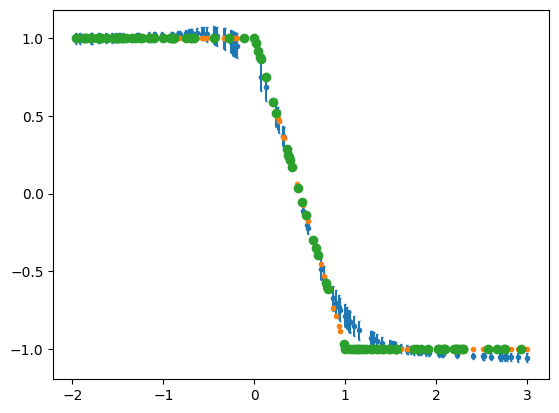

In [28]:
xx1 = tf.constant(-1., shape=(Nout, 1, 1), dtype=tf.float32)
xx2 = tf.constant(1., shape=(Nout, 1, 1), dtype=tf.float32)

alpha_np = alpha_out.numpy()
alpha_np = np.reshape(alpha_out, (Nout,))

x_np = interp(alpha_out)
x_np = np.reshape(x_np.numpy(), (Nout,))
epoch_fix = 999

y = np.array([0.]*len(alpha_np))
erry = np.array([0.]*len(alpha_np))

for i in range(len(alpha_np)):
    y[i] = mean(obser_sum[epoch_fix, 0, i, :])
    erry[i] = np.sqrt(mean(obser_sum[epoch_fix, 1, i, :]) - y[i]**2.)#std_dev(Nboot*obser_sum[epoch_fix, 0, i, :])

#print(erry)

#print(mean(obser_sum[epoch_fix, 0, 0, :]), std_dev(obser_sum[epoch_fix, 0, 0, :])*Nboot**0.5, (mean(obser_sum[epoch_fix, 1, 0, :]) - mean(obser_sum[epoch_fix, 0, 0, :])**2.)**0.5)

#err = np.sqrt(obser_sum[epoch_fix, 1, :] - obser_sum[epoch_fix, 0, :]**2.)
#print(alpha_np[0:5], x_np[0:5], obser_sum[400, 0, 0:5], obser_sum[400, 2, 0:5])
plt.errorbar(alpha_np, y, yerr=2.*erry, fmt = '.', capsize=1)
plt.errorbar(alpha_np, x_np, fmt = '.', capsize=1)
plt.errorbar(np.reshape(alpha_train.numpy(), (Nin, )), np.reshape(x_train.numpy(), (Nin,)), fmt = 'o', capsize=30)
plt.show()

# PUT THE BIAS AT ZERO AND CHANGE THE DEV_STD


# Neural Tangent Kernel (NTK)

#### Definition of the ${\cal T}$ and $\dot{\cal T}$

For the activation function $\phi = {\rm erf}$, we have:

In [29]:
from scipy.linalg import fractional_matrix_power
'''
def Sigma(arr1, arr2):
    Sigma = np.ndarray(shape = (2,2))
    Sigma[0,0] = np.dot(arr1,arr1)
    Sigma[0,1] = np.dot(arr1,arr2)
    Sigma[1,0] = Sigma[0,1]
    Sigma[1,1] = np.dot(arr2,arr2)
    return Sigma

def calT(Sigma):
    #calTp = 4./ np.pi / np.sqrt(np.linalg.det(eye(2) + 2*Sigma))
    calT = 2./np.pi * np.arcsin( 2.* Sigma[0,1] / np.sqrt((1+2*Sigma[0,0])*(1+2*Sigma[1,1])))
    return calT#, calTp
'''

def mathT(a, b, c, d):
    return 2./np.pi * np.arcsin( 2.* b / np.sqrt((1+2*a)*(1+2*d)))

def mathTp(a, b, c, d):
    #det = a*c - b*d
    auxMat = np.empty((2,2))
    auxMat[0,0] = a
    auxMat[0,1] = b
    auxMat[1,0] = c
    auxMat[1,1] = d
    return 4./ np.pi * np.linalg.det(fractional_matrix_power(np.eye(2) + 2*auxMat, -1./2.))
    #return 4./ np.pi / (np.linalg.det(np.eye(2) + 2*auxMat))**2.

For the activation function ReLU $\phi(x) = \max(x, 0)$, we have:

In [30]:
def mathT(a, b, c, d):
    a = np.linalg.norm(a)
    d = np.linalg.norm(d)
    fact_or = b/np.sqrt(a*d)
    output = np.sin(np.arccos(fact_or)) + (np.pi - np.arccos(fact_or))*fact_or
    return 1./2./np.pi * np.sqrt(a*d) * output


def mathTp(a, b, c, d):
    a = np.linalg.norm(a)
    d = np.linalg.norm(d)
    return 1./2./np.pi * (np.pi - np.arccos(b/np.sqrt(a*d)))

The expression ${\cal K}^\ell$ indicates a set of function applied at each $\ell$ layer. Therefore, the ${\cal K}^{L+1}$ corresponds ${\cal K}$.

#### Computing NTK and NNGP Kernel

Definition of the NNGP kernel ${\cal K}$ and the tangent kernel ${\cal \Theta}$ using the Eqs. (S26, S27) and Eq. (S35)

In [31]:
def Kappa(arr1, arr2, l_index, sigma_w, sigma_b, n0):
    if l_index == 1:
        return np.dot(arr1,arr2)/n0*sigma_w**2. + sigma_b**2.
    else:
        T11 = Kappa(arr1, arr1, l_index-1, sigma_w, sigma_b, n0)
        T12 = Kappa(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)
        T21 = T12
        T22 = Kappa(arr2, arr2, l_index-1, sigma_w, sigma_b, n0)
        return sigma_w**2.*mathT(T11, T12, T21, T22) + sigma_b**2.

    
    
def Theta(arr1, arr2, l_index, sigma_w, sigma_b, n0):
    if l_index == 1:
        return np.dot(arr1,arr2)/n0*sigma_w**2. + sigma_b**2.
    else:
        T11 = Kappa(arr1, arr1, l_index-1, sigma_w, sigma_b, n0)
        T12 = Kappa(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)
        T21 = T12
        T22 = Kappa(arr2, arr2, l_index-1, sigma_w, sigma_b, n0)
        return sigma_w**2.*mathTp(T11, T12, T21, T22)*Theta(arr1, arr2, l_index-1, sigma_w, sigma_b, n0)

## NNGP

Writing the mean value and the variance of the output throughout training which converges to a Gaussian distribution from Eqs (S22) and (S23)

In [32]:
from scipy.linalg import expm

def distribNNGP(time, x, input_train, output_train, eta, n_layer, sigma_w, sigma_b, n0):
    tdim = len(input_train)
    Kxx = Kappa(x, x, n_layer+1, sigma_w, sigma_b, n0)
    KxCalX = np.empty((tdim))
    KCalXCalX = np.empty((tdim, tdim))
    
    for index, elem in enumerate(input_train):
        KxCalX[index] = Kappa(x, elem, n_layer+1, sigma_w, sigma_b, n0)
        for jndex in range(index,tdim):
            KCalXCalX[index, jndex] = Kappa(elem, input_train[jndex], n_layer+1, sigma_w, sigma_b, n0)
            KCalXCalX[jndex, index] = KCalXCalX[index, jndex]
            
    K_inverse = np.linalg.inv(KCalXCalX)
    Aux = expm(-eta*KCalXCalX*time)
    Aux1 = np.eye(tdim) - np.matmul(Aux,Aux)
    Aux = np.eye(tdim) - Aux
    #print(Aux, output_train)
    mean = np.matmul(KxCalX, np.matmul(K_inverse, np.matmul(Aux, output_train)))
    variance = Kxx - np.matmul(KxCalX, np.matmul(K_inverse, np.matmul(Aux1, KxCalX.T)))
    
    return mean, np.sqrt(variance)
    

## NKT GP
Using the Eqs. (14, 15)

In [33]:
def distribNKTgp(time, x, input_train, output_train, eta, n_layer, sigma_w, sigma_b, n0):
    tdim = len(input_train)
    Kxx = Kappa(x, x, n_layer+1, sigma_w, sigma_b, n0)
    KxCalX = np.empty((tdim))
    TxCalX = np.empty((tdim))
    KCalXCalX = np.empty((tdim, tdim))
    TCalXCalX = np.empty((tdim, tdim))
    
    for index, elem in enumerate(input_train):
        KxCalX[index] = Kappa(x, elem, n_layer+1, sigma_w, sigma_b, n0)
        TxCalX[index] = Theta(x, elem, n_layer+1, sigma_w, sigma_b, n0)
        for jndex in range(index,tdim):
            KCalXCalX[index, jndex] = Kappa(elem, input_train[jndex], n_layer+1, sigma_w, sigma_b, n0)
            KCalXCalX[jndex, index] = KCalXCalX[index, jndex]
            TCalXCalX[index, jndex] = Theta(elem, input_train[jndex], n_layer+1, sigma_w, sigma_b, n0)
            TCalXCalX[jndex, index] = TCalXCalX[index, jndex]

    T_inverse = np.linalg.inv(TCalXCalX)
    Aux = np.eye(tdim) - expm(-eta*TCalXCalX*time)
    
    mean = np.matmul(TxCalX, np.matmul(T_inverse, np.matmul(Aux, output_train)))
    variance = Kxx + np.matmul(TxCalX, np.matmul(T_inverse, np.matmul(Aux, np.matmul(KCalXCalX, np.matmul(Aux, np.matmul(T_inverse, TxCalX))))))
    vaux = np.matmul(TxCalX, np.matmul(T_inverse, np.matmul(Aux, KxCalX)))
    variance -= vaux + np.conj(vaux)
    return mean, np.sqrt(variance)

## Experiment

<span style="color:red;">ATTENTION: using different activation function the training initial data can lead to a non valid value error, then, for the moment, relunch the code, in the case we select the tf.random.generator_array</span>

<span style='color:purple;'>ATTENTION: instead, if you use the np.random.array, only the ${\rm ReLU}$ activation function formulas converge.<br>
<u>**IN THIS CASE, ALL WORK !!!**</u></span>

In [34]:
Nin = 150
Nout = 100

xx1 = -1
xx2 = 1

def interp_np(_alpha):
    condition1 = tf.logical_and(_alpha <= 1, _alpha >= 0)
    condition2 = _alpha > 1
    condition3 = _alpha < 0
    
    result = np.where(condition1, _alpha * xx1 + (1 - _alpha) * xx2, tf.where(condition2, xx1, xx2))
    return result

#print(x_train)CASE
#sys.exit()

sigma_w = np.sqrt(1.5)
sigma_b = 1.
Mu = 0.
STD = 1.
Nboot = 10
depth = 3
input_size = 1
hidden_size = 32
output_size = 1
eta = 0.1
n0 = 1

'''
xx1 = tf.constant(-1., shape=(Nin, 1, 1), dtype=tf.float32)
xx2 = tf.constant(1., shape=(Nin, 1, 1), dtype=tf.float32)

alpha_train = tf.random.uniform(shape=(Nin,1,1), minval=-2, maxval=3, dtype=tf.float32)
#alpha_train = tf.constant([[[0]], [[1]]], shape=(2, 1, 1), dtype=tf.float32)
x_train = interp(alpha_train)

alpha_train_np = alpha_train.numpy()
x_train_np = np.reshape(x_train.numpy(), (Nin,))

xx1 = tf.constant(-1., shape=(Nout, 1, 1), dtype=tf.float32)
xx2 = tf.constant(1., shape=(Nout, 1, 1), dtype=tf.float32)

alpha_out = tf.random.uniform(shape=(Nout,1,1), minval=-2, maxval=3, dtype=tf.float32)
x_out = interp(alpha_out)

alpha_out_np = alpha_out.numpy()
alpha_out_np = np.reshape(alpha_out_np, (Nout,))

x_out_np = np.reshape(x_out.numpy(), (Nout,))
'''

alpha_train_np = np.random.uniform(-2, 3, Nin)
#alpha_train = tf.constant([[[0]], [[1]]], shape=(2, 1, 1), dtype=tf.float32)
x_train_np = interp_np(alpha_train_np)

alpha_out_np = np.random.uniform(-2, 3, Nout)
x_out = interp_np(alpha_out_np)

#print(x_train_np)

In [35]:
#time = 90
alpha_test = np.array([0.6])
print(interp_np(alpha_test)[0])

-0.19999999999999996


In [36]:
time = 1200000
print(distribNKTgp(time, alpha_test, alpha_train_np, x_train_np, eta, depth, sigma_w, sigma_b, n0))

(-0.20000799744331224, 0.000822175321631991)


In [37]:
print(distribNNGP(time, alpha_test, alpha_train_np, x_train_np, eta, depth, sigma_w, sigma_b, n0))

(-0.1998035599089235, nan)


/tmp/ipykernel_185416/136304387.py:23: RuntimeWarning: invalid value encountered in sqrt
  return mean, np.sqrt(variance)


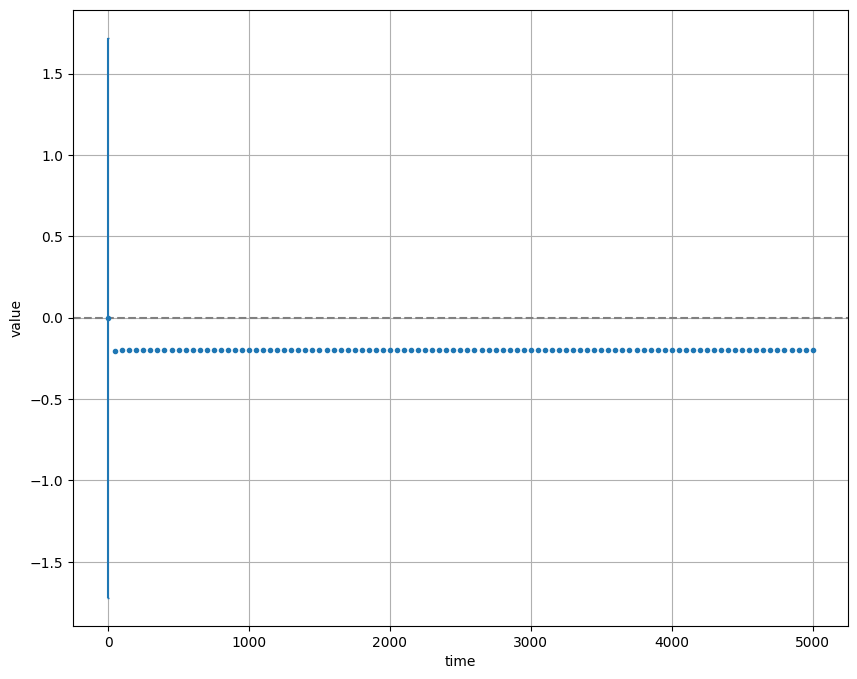

In [38]:
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output

tmax = 5000
dtime = tmax / 100
ttime = 0

fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.set_ylabel("value")
ax.set_xlabel("time")

xvalues = []
err_xval = []
time_set = []

def update(frame):
    
    global ttime
    
    mean, st_dd = distribNKTgp(ttime, alpha_test, alpha_train_np, x_train_np, eta, depth, sigma_w, sigma_b, n0)
    xvalues.append(mean)
    err_xval.append(st_dd)
    time_set.append(ttime)
    ttime += dtime
    
    ax.clear()   
    ax.grid(True)
    
    ax.errorbar(np.array(time_set), np.array(xvalues), yerr=np.array(err_xval), fmt = '.', capsize=1)
    ax.axhline(0.0,color='grey',linestyle='--')
    
    ax.set_ylabel("value")
    ax.set_xlabel("time")


animation = FuncAnimation(fig, update, frames=100)  # Update plot every 100 milliseconds


for i in range(100):
    animation._func(i)
    display(fig)
    clear_output(wait=True)

#for i in tqdm(range(30), desc="Progress", ncols=100):
#    mean, st_dd = distribNKTgp(ttime, alpha_test, alpha_train_np, x_train_np, eta, depth, sigma_w, sigma_b, n0)
    #print(mean)
#    xvalues.append(mean)
#    err_xval.append(st_dd)
#    time_set.append(ttime)
#    ttime += dtime


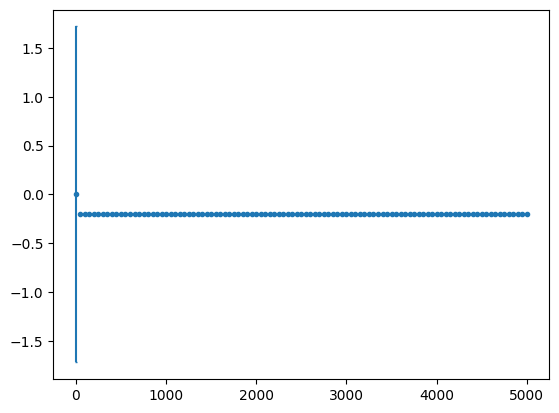

In [39]:
#print(xvalues)
array_set = [time_set, xvalues, err_xval]

# Create a mask to erase the first element of each array
mask = [slice(0, None) for _ in array_set]
# Apply the mask to the array set to erase the first element
array_set = [array[mask_] for array, mask_ in zip(array_set, mask)]

plt.errorbar(np.array(array_set[0]), np.array(array_set[1]), yerr=np.array(array_set[2]), fmt = '.', capsize=1)
plt.show()